In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import skimage.io as io
import skimage.exposure as exposure
from skimage.exposure import equalize_hist
from skimage.color import rgb2gray
import skimage.transform as transform
import numpy as np
import re
from skimage import feature
from skimage.filters import roberts, sobel, scharr, prewitt
from sklearn.decomposition import RandomizedPCA
from sklearn.manifold import TSNE
import pylab as pl

In [2]:
pic_data = pd.read_csv('../data/menu_match_dataset/basic_info.csv')

In [3]:
# Fix issue with name of lasagna
def is_type(t,l):
    for i in (range(len(l))):
        if re.search(t, l[i]):
            return 1
    return 0

pic_data = pic_data.fillna('')
pic_data['lasagne'] = pic_data[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('lasagna',row), axis=1)

In [4]:
chicken = pic_data[(pic_data['chicken'] == 1) & (pic_data['num_labels'] == 1)]
pizzas = pic_data[(pic_data['pizza'] == 1) & (pic_data['num_labels'] == 1)]
lasagne = pic_data[(pic_data['lasagne'] == 1) & (pic_data['num_labels'] == 1)]

In [5]:
print("There are {} images with one class containing chicken".format(len(chicken)))
print("There are {} images with one class containing pizza".format(len(pizzas)))
print("There are {} images with one class containing lasagne".format(len(lasagne)))

There are 6 images with one class containing chicken
There are 87 images with one class containing pizza
There are 4 images with one class containing lasagne


In [6]:
# Look at different image sizes
pizzas.groupby("image_shape").size().sort_values(ascending=False)

image_shape
(1000, 1776, 3)    25
(1776, 1000, 3)    19
(1632, 1224, 3)    18
(968, 1296, 3)      8
(920, 1632, 3)      8
(1632, 920, 3)      4
(1296, 968, 3)      3
(992, 825, 3)       1
(940, 973, 3)       1
dtype: int64

In [7]:
# Sub group 1 has shape (1000, 1776, 3)
sub_gp_1 = pizzas[pizzas["image_shape"] == "(1000, 1776, 3)"]
pizza_pics = []
for f in sub_gp_1['image_name']:
    pizza_pics.append(io.imread('../data/menu_match_dataset/foodimages/' + f))

In [8]:
# Sub group 2 has the same shape just rotated
sub_gp_2 = pizzas[pizzas["image_shape"] == "(1776, 1000, 3)"]
#Read image and rotate 90 degrees prior to adding to list
for f in sub_gp_2['image_name']:
    im = io.imread('../data/menu_match_dataset/foodimages/' + f)
    im = transform.rotate(im, 90, resize=True)
    pizza_pics.append(im)

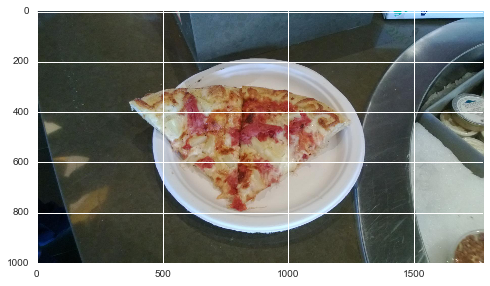

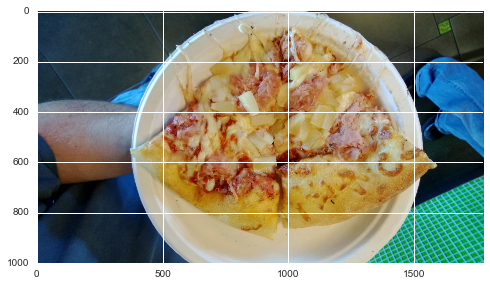

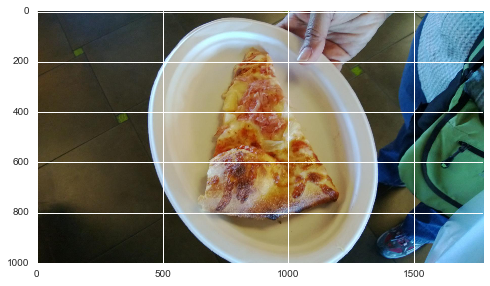

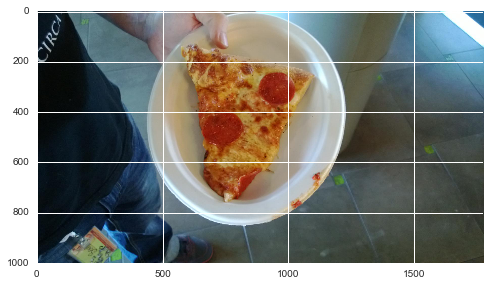

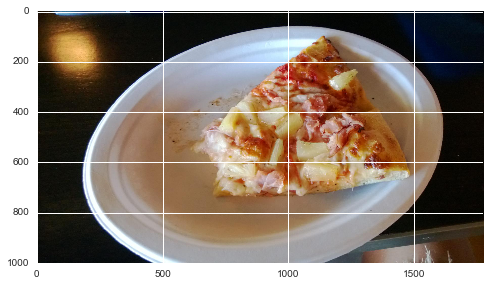

In [9]:
# Look at first 5 images
for ima in pizza_pics[0:5]:
    plt.figure()
    plt.imshow(ima)

In [10]:
# Look at chicken category
chicken.groupby("image_shape").size().sort_values(ascending=False)

image_shape
(1632, 1224, 3)    4
(1632, 920, 3)     1
(1296, 968, 3)     1
dtype: int64

In [11]:
sub_gp_1 = chicken[chicken["image_shape"] == "(1632, 1224, 3)"]
chicken_pics = []
for f in sub_gp_1['image_name']:
    chicken_pics.append(io.imread('../data/menu_match_dataset/foodimages/' + f))

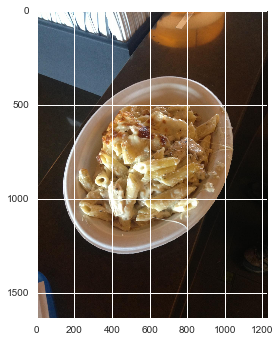

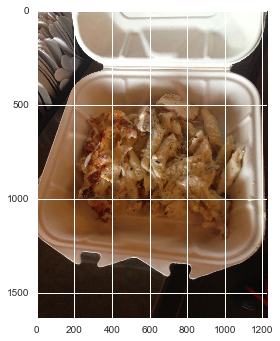

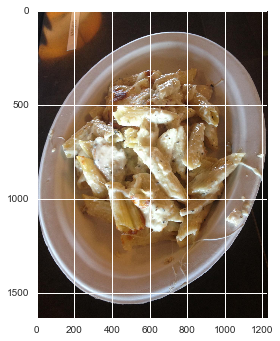

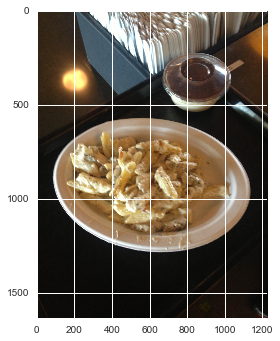

In [12]:
for ima in chicken_pics:
    plt.figure()
    plt.imshow(ima)

In [13]:
# Finally look at Lasagne category
lasagne.groupby("image_shape").size().sort_values(ascending=False)

image_shape
(1776, 1000, 3)    1
(1632, 920, 3)     1
(1632, 1224, 3)    1
(1000, 1776, 3)    1
dtype: int64

In [14]:
sub_gp_1 = lasagne[lasagne["image_shape"] == "(1776, 1000, 3)"]
sub_gp_2 = lasagne[lasagne["image_shape"] == "(1000, 1776, 3)"]
lasagne_pics = []
for f in sub_gp_1['image_name']:
    im = io.imread('../data/menu_match_dataset/foodimages/' + f)
    im = transform.rotate(im, 90, resize=True)
    lasagne_pics.append(im)
    
for f in sub_gp_2['image_name']:    
    lasagne_pics.append(io.imread('../data/menu_match_dataset/foodimages/' + f))

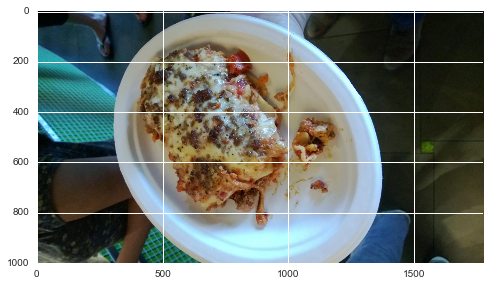

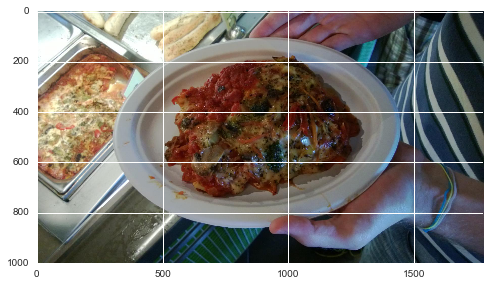

In [15]:
for ima in lasagne_pics:
    plt.figure()
    plt.imshow(ima)

/Users/simonbedford/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


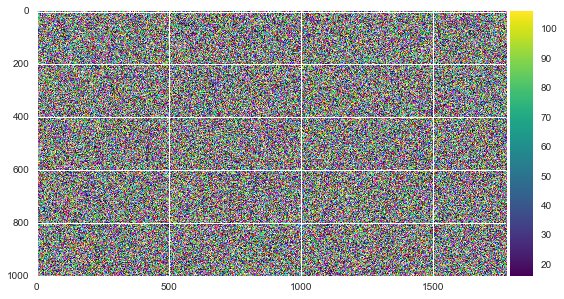

In [16]:
# Is there such a thing as an 'average' pizza image?
pizza_col_avg = np.zeros(shape = (1000, 1776, 3))
for p in pizza_pics:
    pizza_col_avg += p
pizza_col_avg = pizza_col_avg/float(len(pizza_pics))

io.imshow(pizza_col_avg);

/Users/simonbedford/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


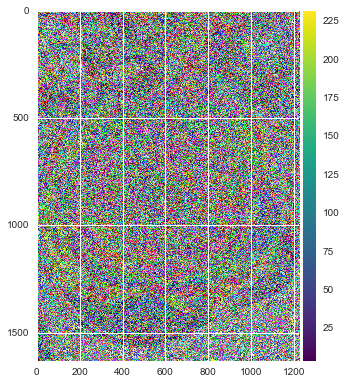

In [17]:
# Is there such a thing as an 'average' chicken image?
chicken_col_avg = np.zeros(shape = (1632, 1224, 3))
for p in chicken_pics:
    chicken_col_avg += p
chicken_col_avg = chicken_col_avg/float(len(chicken_pics))

io.imshow(chicken_col_avg);

/Users/simonbedford/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


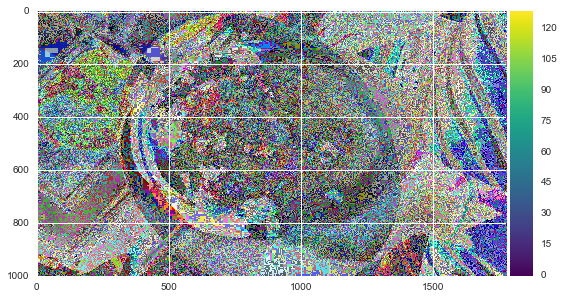

In [18]:
# Is there such a thing as an 'average' lasagne image?
lasagne_col_avg = np.zeros(shape = (1000, 1776, 3))
for p in lasagne_pics:
    lasagne_col_avg += p
lasagne_col_avg = lasagne_col_avg/float(len(lasagne_pics))

io.imshow(lasagne_col_avg);

/Users/simonbedford/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


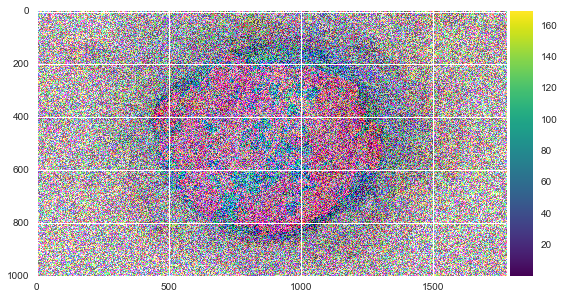

In [19]:
# Median pizza image
pizza_col_med = np.median(np.array(pizza_pics), axis=0)
io.imshow(pizza_col_med);

/Users/simonbedford/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


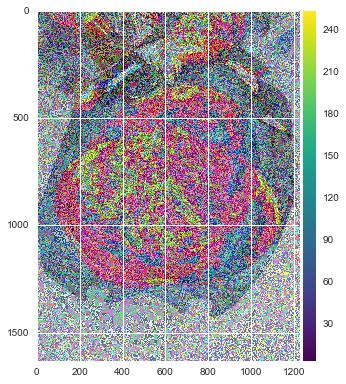

In [20]:
# Median chicken image
chicken_col_med = np.median(np.array(chicken_pics), axis=0)
io.imshow(chicken_col_med);

/Users/simonbedford/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


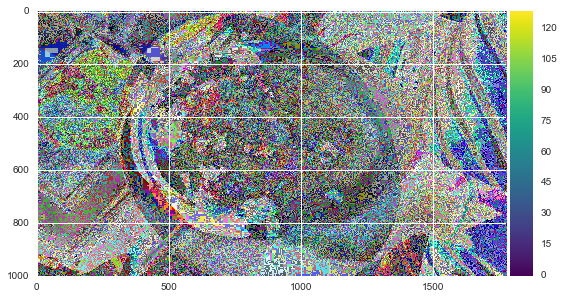

In [21]:
# Median lasagne image
lasagne_col_med = np.median(np.array(lasagne_pics), axis=0)
io.imshow(lasagne_col_med);

In [22]:
names = ['Pizza', 'Chicken', 'Lasagne']
images_avg = [pizza_col_avg, chicken_col_avg, lasagne_col_avg]

In [23]:
def get_histogram(image, channel):
    """
    Calculates histogram and bins for an image based on a particular channel
    image: image for calculating histogram
    channel: can be 0, 1 or two for color images, or 3 to specify greyscale
    return: array of bin counts, array of bins
    """
    if channel == 3:
        return exposure.histogram(image)
    else:
        return exposure.histogram(image[:,:,channel])

In [24]:
def plot_histogram(images, names, channel):
    """
    Plots side-by-side histograms for a set of 3 images and a specified channel
    images: set of images
    names: image names
    channel: can be 0, 1 or two for color images, or 3 to specify greyscale
    """
    colors = {0: '#e41a1c', 1: '#4daf4a', 2: '#377eb8', 3: '#878787'}
    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
    for ax, image, name in zip(axes, images_avg, names):
        hist, bins = get_histogram(image, channel)
        width = bins[1] - bins[0]
        ax.bar(bins, hist, align='center', width=width, alpha=0.5, color=colors[channel], axes=ax)
        ax.set_title("{}".format(name), weight='bold')
    fig.tight_layout()

##### Look at histograms for RGB values for average images

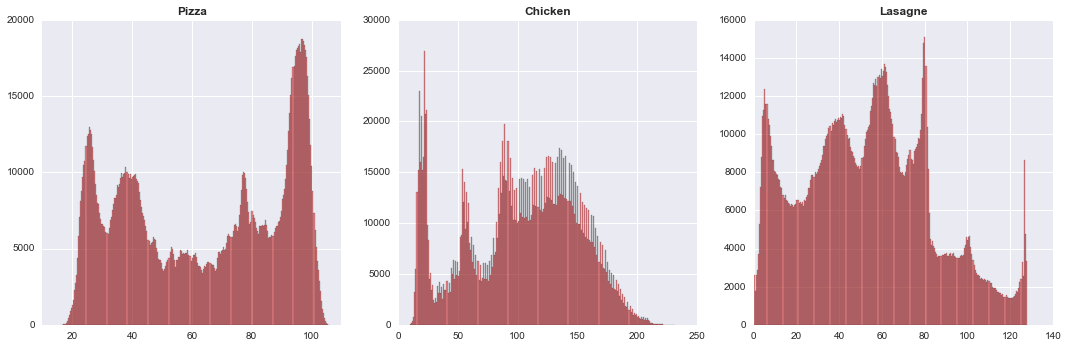

In [25]:
plot_histogram(images_avg, names, 0)

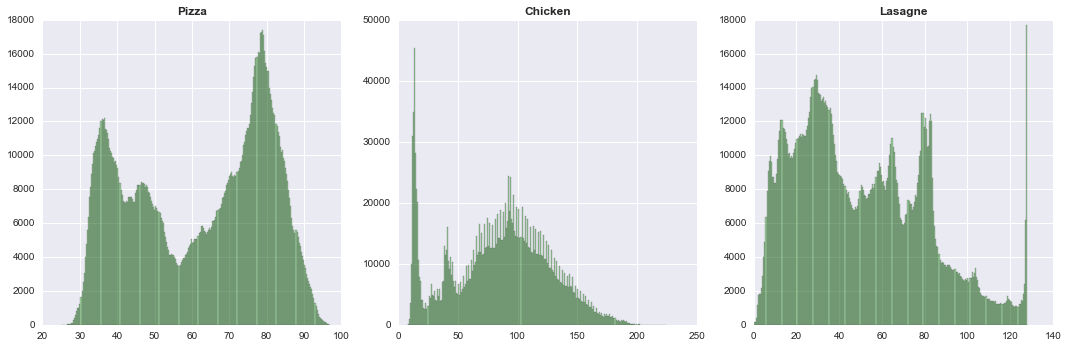

In [26]:
plot_histogram(images_avg, names, 1)

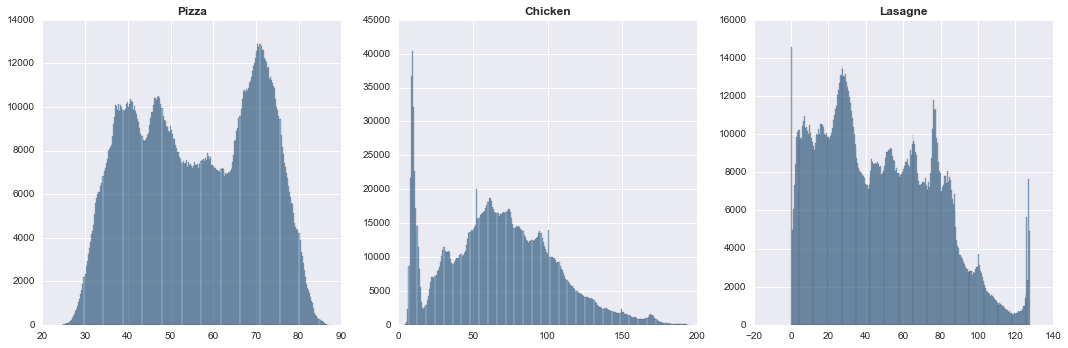

In [27]:
plot_histogram(images_avg, names, 2)

##### Histograms for RGB for median images

In [28]:
images_med = [pizza_col_med, chicken_col_med, lasagne_col_med]

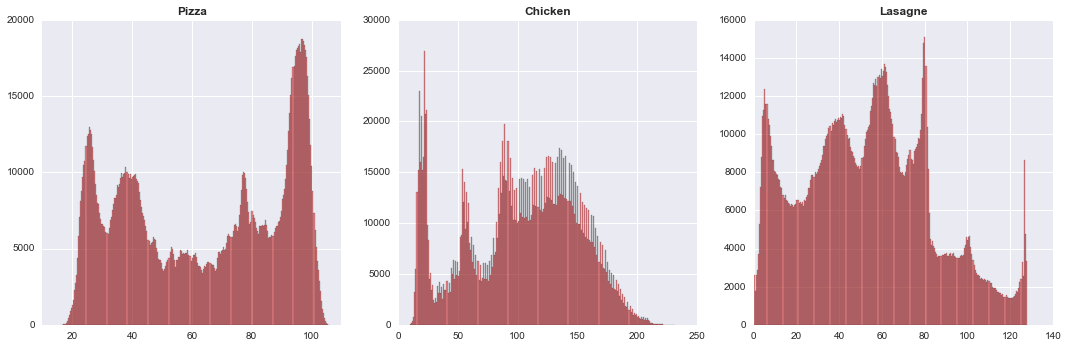

In [29]:
plot_histogram(images_med, names, 0)

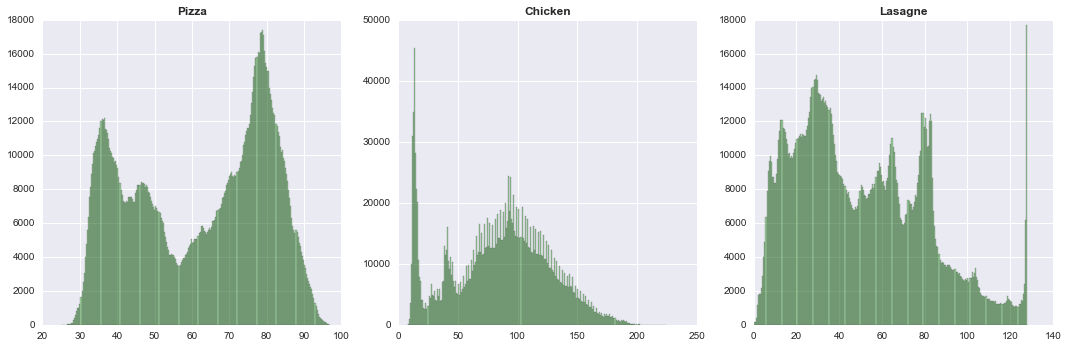

In [30]:
plot_histogram(images_med, names, 1)

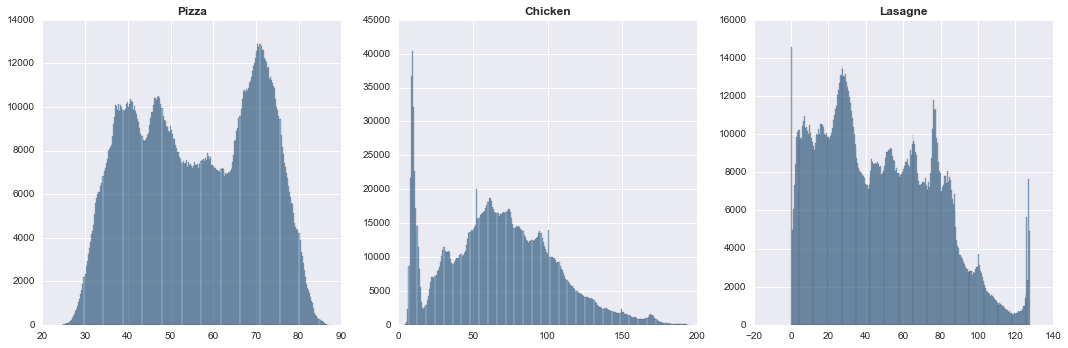

In [31]:
plot_histogram(images_med, names, 2)

##### Find 'closest' image to the average image for each food type

In [32]:
def nearest_neighbor(image, image_set):
    """
    For a specified image represented as array finds the nearest neighbor in a separate set of images using Frobenius norm
    image: array representing the specified image
    image_set: enumerable object containing the set of images to use for finding the nearest neighbor
    returns: index of nearest neighbor in image_set
    """
    distances = {}
    for i, im in enumerate(image_set):
        distances[i] = np.linalg.norm(image - im)
    return min(distances, key=distances.get)

In [33]:
rep_pizza = pizza_pics[nearest_neighbor(pizza_col_avg, pizza_pics)]
rep_chicken = chicken_pics[nearest_neighbor(chicken_col_avg, chicken_pics)]
rep_lasagne = lasagne_pics[nearest_neighbor(lasagne_col_avg, lasagne_pics)]

In [34]:
rep_pizza_g = rgb2gray(rep_pizza)
rep_chicken_g = rgb2gray(rep_chicken)
rep_lasagne_g = rgb2gray(rep_lasagne)

##### Plot histogram for greyscale representative images

/Users/simonbedford/anaconda3/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


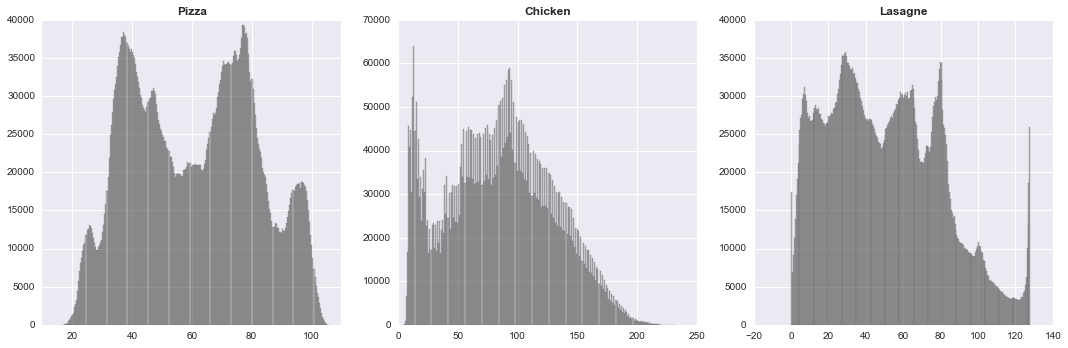

In [35]:
images_grey = [rep_pizza_g, rep_chicken_g, rep_lasagne_g]
plot_histogram(images_grey, names, 3)

##### Canny edge detection on representative greyscale images

Canny Edges Sigma = 1


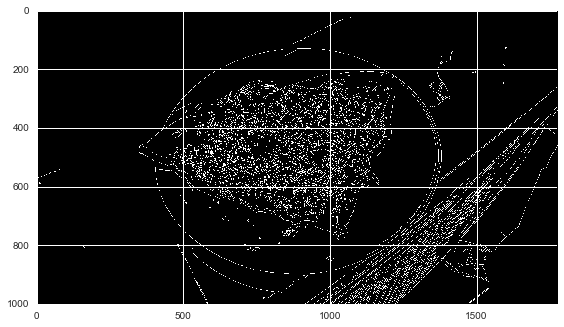

Canny Edges Sigma = 3


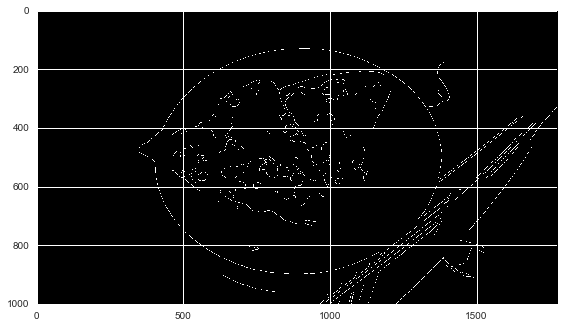

In [36]:
# Pizza edges
pizza_edge_1 = feature.canny(rep_pizza_g)
pizza_edge_2 = feature.canny(rep_pizza_g, sigma=3)

print('Canny Edges Sigma = 1')
io.imshow(pizza_edge_1)
io.show()
print('Canny Edges Sigma = 3')
io.imshow(pizza_edge_2)
io.show()

Canny Edges Sigma = 1


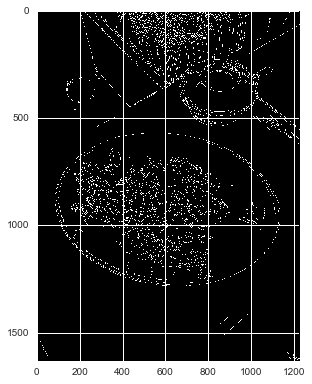

Canny Edges Sigma = 3


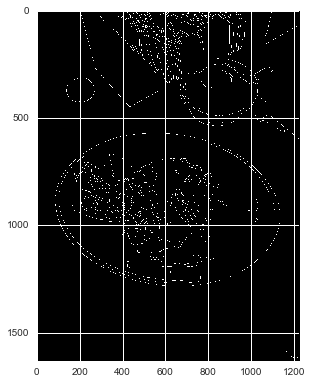

In [37]:
# Chicken edges
chicken_edge_1 = feature.canny(rep_chicken_g)
chicken_edge_2 = feature.canny(rep_chicken_g, sigma=3)

print('Canny Edges Sigma = 1')
io.imshow(chicken_edge_1)
io.show()
print('Canny Edges Sigma = 3')
io.imshow(chicken_edge_2)
io.show()

Canny Edges Sigma = 1


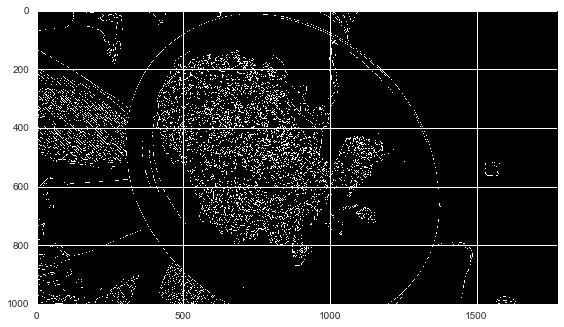

Canny Edges Sigma = 3


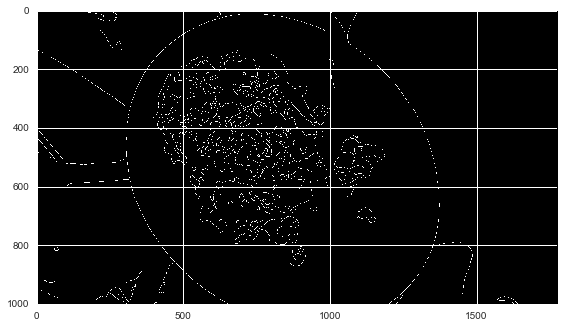

In [38]:
# Lasagne edges
lasagne_edge_1 = feature.canny(rep_lasagne_g)
lasagne_edge_2 = feature.canny(rep_lasagne_g, sigma=3)

print('Canny Edges Sigma = 1')
io.imshow(lasagne_edge_1)
io.show()
print('Canny Edges Sigma = 3')
io.imshow(lasagne_edge_2)
io.show()

##### Have a go at PCA for the set of pizza images

In [39]:
data = []
for image in pizza_pics:
    img = image.flatten()
    data.append(img)
data = np.array(data)

In [40]:
pca = RandomizedPCA(n_components=2)
X = pca.fit_transform(data)

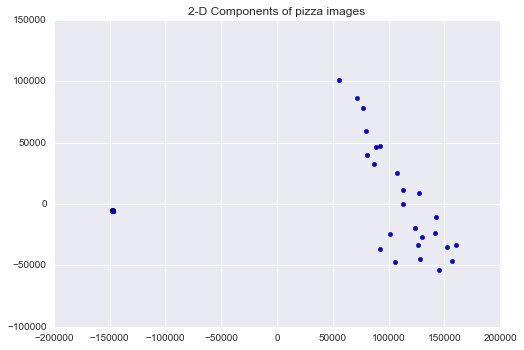

In [41]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])
ax.set_title("2-D Components of pizza images")
plt.show()

Try plotting all images on 2 dimensions

In [85]:
def standardize(image, size):
    """
    Standardizes an image by ensuring standard rotation with largest dimension first, and then reshaping to a fixed size
    :params image: image as numpy array
    :params size: tuple representing standard size
    :return: flattened, standardized image as numpy array
    """
    im = image
    dim = image.shape
    if dim[1] > dim[0]:
        im = transform.rotate(im, 90, resize=True)
    
    im = transform.resize(im, size)
    return im.flatten()

In [87]:
standard_size = (633, 996, 3)

pizza_list = list(pic_data[(pic_data['pizza'] == 1) & (pic_data['num_labels'] == 1)]['image_name'])
n_pizza = len(pizza_list)

chicken_list = list(pic_data[(pic_data['chicken'] == 1) & (pic_data['num_labels'] == 1)]['image_name'])
n_chicken = len(chicken_list)

lasagne_list = list(pic_data[(pic_data['lasagne'] == 1) & (pic_data['num_labels'] == 1)]['image_name'])
n_lasagne = len(lasagne_list)

(n_pizza, n_chicken, n_lasagne)

data = []

for i in pizza_list + chicken_list + lasagne_list:
    image = io.imread('../data/menu_match_dataset/foodimages/' + i)
    data.append(standardize(image, standard_size))

In [88]:
pca = RandomizedPCA(n_components=50)
X = pca.fit_transform(data)

In [89]:
model = TSNE(n_components=2, random_state=0)
transformed = model.fit_transform(X)

In [90]:
fitted_pizza = transformed[:n_pizza]
fitted_chicken = transformed[n_pizza:n_pizza + n_chicken]
fitted_lasagne = transformed[n_pizza + n_chicken:]

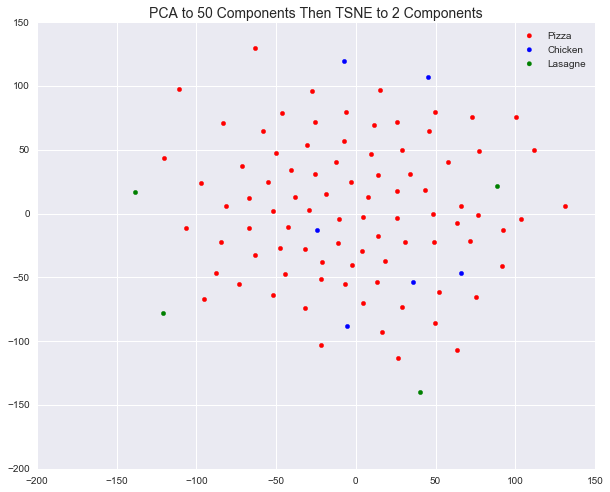

In [96]:
fig, ax = plt.subplots(figsize=(10,8))

x = fitted_pizza[:,0]
y = fitted_pizza[:,1]
ax.scatter(x, y, color='red', label='Pizza')

x = fitted_chicken[:,0]
y = fitted_chicken[:,1]
ax.scatter(x, y, color='blue', label='Chicken')

x = fitted_lasagne[:,0]
y = fitted_lasagne[:,1]
ax.scatter(x, y, color='green', label='Lasagne')

ax.set_title('PCA to 50 Components Then TSNE to 2 Components', fontsize='14')
ax.legend()
plt.show()

In [97]:
model = TSNE(n_components=2, random_state=0)
transformed = model.fit_transform(data)

In [98]:
fitted_pizza = transformed[:n_pizza]
fitted_chicken = transformed[n_pizza:n_pizza + n_chicken]
fitted_lasagne = transformed[n_pizza + n_chicken:]

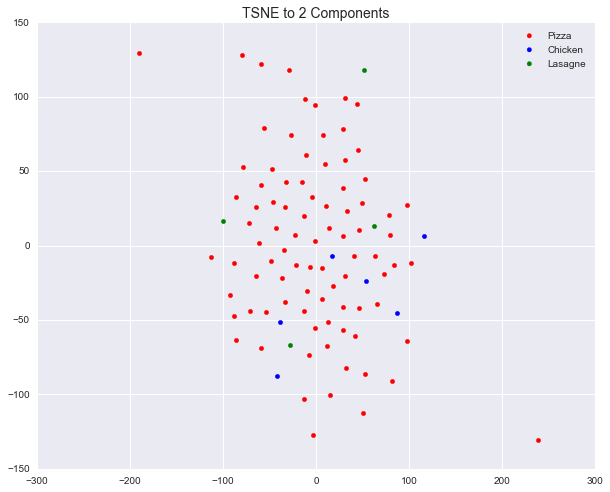

In [99]:
fig, ax = plt.subplots(figsize=(10,8))

x = fitted_pizza[:,0]
y = fitted_pizza[:,1]
ax.scatter(x, y, color='red', label='Pizza')

x = fitted_chicken[:,0]
y = fitted_chicken[:,1]
ax.scatter(x, y, color='blue', label='Chicken')

x = fitted_lasagne[:,0]
y = fitted_lasagne[:,1]
ax.scatter(x, y, color='green', label='Lasagne')

ax.set_title('TSNE to 2 Components', fontsize='14')
ax.legend()
plt.show()